Code Explanation: FYI, the first part of the code works showing distances to picker depot. 2nd part - the visualization part of the code - takes about 1hr to complete and looks extremely scuffed due to labeling. (storage location graph with weighted edges)

This code implements functionalities for modeling a warehouse layout, including generating storage locations, constructing a graph, and manipulating attributes such as distances between locations

Creates racks and generates storage locations in a grid layout. It subdivides racks into shelves and positions storage locations within each rack analog to our physcial rack naming conventions, aswell as its layout. (simplified)
    For each rack:
    1. A rectangular polygon is created to represent the rack.
    2. Each rack is divided into shelves (`ABCDEFGH`) and further into ten storage locations per shelf.
    3. Each storage location is labeled uniquely, combining the rack position, shelf (`A-H`), and storage slot (`01-10`).

- Creates a matrix storing the Euclidean distances between all storage locations.
- Ranks all storage locations based on their shortest distance to the depot.
- prints the ranked list of storage locations and their distances.
    - Outputs the rank, label, and distance to the terminal.
    - Formats distances to two decimal points for readability.

In [1]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
import networkx as nx


In [13]:
def generate_storage_locations(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates rack polygons and storage location vertices.
    Each rack has 8 shelves and 10 storage locations per shelf.
    :param rows: Number of rows of racks
    :param cols: Number of columns of racks
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks in mm
    :return: (list of rack polygons, list of storage locations with labels)
    """
    rack_polygons = [] # will store geometric shapes of racks
    storage_locations = []  # List of (coordinates, label) tuples

    for row in range(rows):
        for col in range(cols):
            # determines Bottom-left corner of the rack, and includes walkways between racks
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a polygon (rectangular) for the rack
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Generate storage locations (identifier) for this rack, two-digit for row and column
            rack_id = f"{row + 1:02}{col + 1:02}"  # Rack identifier
            shelf_height = rack_height / 8  # Divide rack height into 8 shelves
            location_width = rack_width / 10  # Divide rack width into 10 locations

            # iterates through each shelf (A-H) and location on shelf (1-10), total 80 locations per rack
            for shelf_idx, shelf_letter in enumerate("ABCDEFGH"):  # 8 shelves
                for loc_idx in range(10):  # 10 locations per shelf
                    #calculate storage location coordinates, adds half width/height to center the point in storage space
                    x_loc = x_start + loc_idx * location_width + location_width / 2
                    y_loc = y_start + shelf_idx * shelf_height + shelf_height / 2
                    label = f"{rack_id}{shelf_letter}{loc_idx + 1:02}"
                    storage_locations.append(((x_loc, y_loc), label)) # store coordinate and label as tuple

    return rack_polygons, storage_locations 


def add_picker_depot(storage_locations, depot_x=0, depot_y=-2000):
    """
    Adds the picker depot as a storage location.
    :param storage_locations: List of (coordinates, label) tuples for storage locations
    :param depot_x: X-coordinate of the depot
    :param depot_y: Y-coordinate of the depot
    :return: Updated storage locations, depot label
    """
    depot_label = "Depot"
    storage_locations.append(((depot_x, depot_y), depot_label))
    return storage_locations, depot_label


In [14]:
def generate_weighted_adjacency_matrix_with_labels(storage_locations):
    """
    Generates the weighted adjacency matrix for all storage locations.
    :param storage_locations: List of (coordinates, label) tuples
    :return: Weighted adjacency matrix, mapping of labels to indices
    """
    N = len(storage_locations)
    weightedAdjaMatrix = np.zeros((N, N))  # Initialize matrix
    label_to_index = {label: idx for idx, (_, label) in enumerate(storage_locations)}

    for i in range(N):
        for j in range(i + 1, N):  # Upper triangular matrix
            coord_i, _ = storage_locations[i]
            coord_j, _ = storage_locations[j]

            # Compute Euclidean distance
            distance = np.sqrt((coord_i[0] - coord_j[0])**2 + (coord_i[1] - coord_j[1])**2)
            weightedAdjaMatrix[i, j] = distance
            weightedAdjaMatrix[j, i] = distance  # Symmetric

    return weightedAdjaMatrix, label_to_index


In [15]:
def generate_weighted_adjacency_matrix_with_labels(storage_locations):
    """
    Generates the weighted adjacency matrix for all storage locations.
    :param storage_locations: List of (coordinates, label) tuples
    :return: Weighted adjacency matrix, mapping of labels to indices
    """
    N = len(storage_locations)
    weightedAdjaMatrix = np.zeros((N, N))  # Initialize matrix
    label_to_index = {label: idx for idx, (_, label) in enumerate(storage_locations)}

    for i in range(N):
        for j in range(i + 1, N):  # Upper triangular matrix
            coord_i, _ = storage_locations[i]
            coord_j, _ = storage_locations[j]

            # Compute Euclidean distance
            distance = np.sqrt((coord_i[0] - coord_j[0])**2 + (coord_i[1] - coord_j[1])**2)
            weightedAdjaMatrix[i, j] = distance
            weightedAdjaMatrix[j, i] = distance  # Symmetric

    return weightedAdjaMatrix, label_to_index


In [16]:
def rank_storage_locations_by_distance(storage_locations, depot_label, weightedAdjaMatrix, label_to_index):
    """
    Ranks storage locations based on the shortest distance to the depot.
    :param storage_locations: List of (coordinates, label) tuples
    :param depot_label: Label of the picker depot
    :param weightedAdjaMatrix: Weighted adjacency matrix
    :param label_to_index: Mapping of labels to indices
    :return: List of ranked locations [(label, distance, rank)]
    """
    depot_index = label_to_index[depot_label]  # Index of the depot in the adjacency matrix

    # Retrieve all distances from the depot
    distances = [
        (storage_locations[i][1], weightedAdjaMatrix[depot_index][i])  # (label, distance)
        for i in range(len(storage_locations))
    ]

    # Sort by distance (ascending)
    distances.sort(key=lambda x: x[1])

    # Assign rank based on sorted order
    ranked_locations = [(label, dist, rank + 1) for rank, (label, dist) in enumerate(distances)]

    return ranked_locations


In [17]:
def visualize_ranked_storage_locations(ranked_locations):
    """
    Displays the ranked storage locations and distances.
    :param ranked_locations: List of ranked locations [(label, distance, rank)]
    """
    print(f"{'Rank':<5} {'Location':<10} {'Distance (mm)':<15}")
    print("-" * 30)
    for rank, (label, distance, _) in enumerate(ranked_locations):
        print(f"{rank + 1:<5} {label:<10} {distance:.2f}")


In [18]:
def construct_weighted_graph_with_labels(storage_locations, weightedAdjaMatrix):
    """
    Constructs a weighted graph using NetworkX.
    :param storage_locations: List of (coordinates, label) tuples
    :param weightedAdjaMatrix: Weighted adjacency matrix
    :return: NetworkX graph
    """
    G = nx.Graph()

    # Add nodes
    for idx, (coord, label) in enumerate(storage_locations):
        G.add_node(idx, pos=coord, label=label)

    # Add edges with weights
    N = len(storage_locations)
    for i in range(N):
        for j in range(i + 1, N):
            if weightedAdjaMatrix[i, j] > 0:  # Add edges only for valid distances
                G.add_edge(i, j, weight=weightedAdjaMatrix[i, j])

    return G


def visualize_weighted_graph_with_labels(G):
    """
    Visualizes the weighted graph with labels for nodes and edges.
    :param G: NetworkX graph
    """
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw graph
    plt.figure(figsize=(15, 12))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=8)
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    )
    plt.title("Storage Location Graph with Weighted Edges")
    plt.show()


Ranked Storage Locations:
Rank 1: Location Depot, Distance = 0.00 mm
Rank 2: Location 0101A01, Distance = 2250.56 mm
Rank 3: Location 0101A02, Distance = 2254.99 mm
Rank 4: Location 0101A03, Distance = 2263.85 mm
Rank 5: Location 0101A04, Distance = 2277.06 mm
Rank 6: Location 0101A05, Distance = 2294.56 mm
Rank 7: Location 0101A06, Distance = 2316.25 mm
Rank 8: Location 0101A07, Distance = 2342.01 mm
Rank 9: Location 0101A08, Distance = 2371.71 mm
Rank 10: Location 0101A09, Distance = 2405.20 mm
Rank 11: Location 0101A10, Distance = 2442.33 mm
Rank 12: Location 0101B01, Distance = 2750.45 mm
Rank 13: Location 0101B02, Distance = 2754.09 mm
Rank 14: Location 0101B03, Distance = 2761.34 mm
Rank 15: Location 0101B04, Distance = 2772.18 mm
Rank 16: Location 0101B05, Distance = 2786.57 mm
Rank 17: Location 0101B06, Distance = 2804.46 mm
Rank 18: Location 0101B07, Distance = 2825.77 mm
Rank 19: Location 0101B08, Distance = 2850.44 mm
Rank 20: Location 0101B09, Distance = 2878.37 mm
Rank 21:

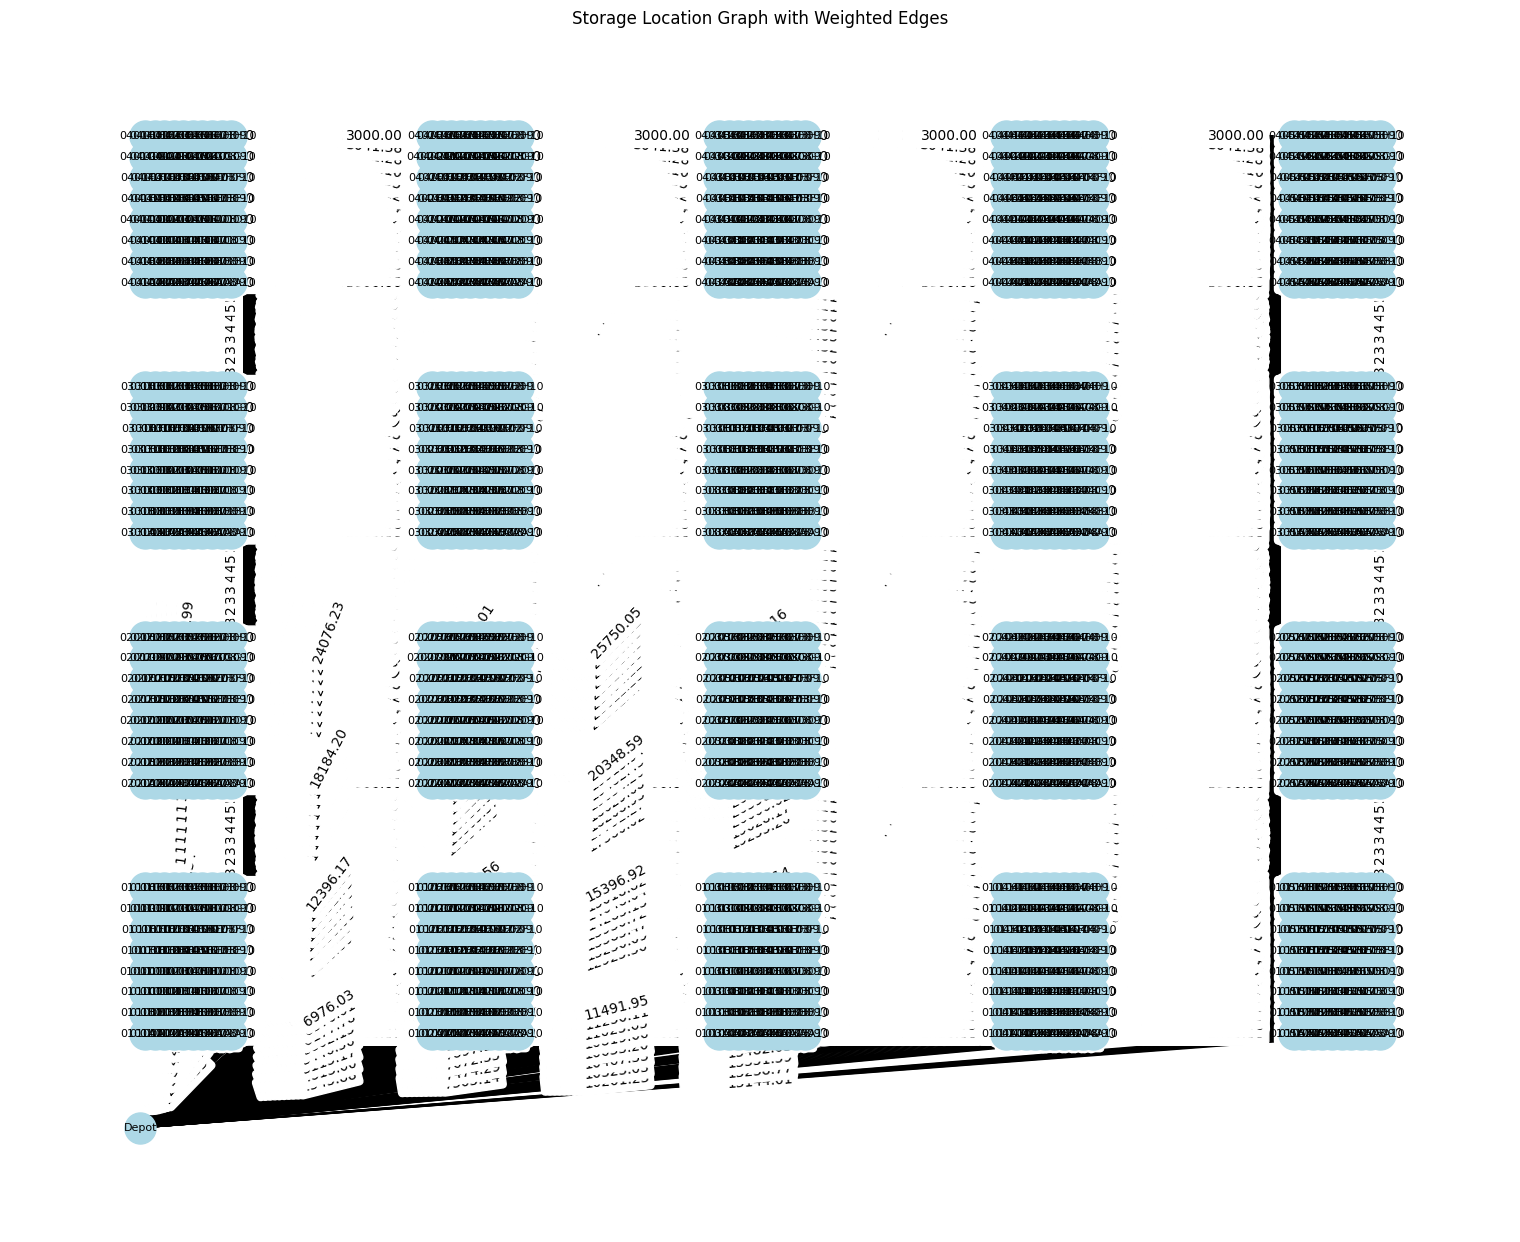

In [19]:
# Define warehouse layout parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000

# Generate racks and storage locations
rack_polygons, storage_locations = generate_storage_locations(rows, cols, rack_width, rack_height, walkway_width)

# Add picker depot
storage_locations, depot_label = add_picker_depot(storage_locations)

# Generate weighted adjacency matrix
weightedAdjaMatrix, label_to_index = generate_weighted_adjacency_matrix_with_labels(storage_locations)

# Rank storage locations by shortest distance to the depot
ranked_locations = rank_storage_locations_by_distance(storage_locations, depot_label, weightedAdjaMatrix, label_to_index)

# Display ranked storage locations
print("Ranked Storage Locations:")
for label, dist, rank in ranked_locations:
    print(f"Rank {rank}: Location {label}, Distance = {dist:.2f} mm")

# Construct the weighted graph
G = construct_weighted_graph_with_labels(storage_locations, weightedAdjaMatrix)

# Visualize the weighted graph
visualize_weighted_graph_with_labels(G)
